# This code reads the IRF of CTAO-N and saves the files in the format needed for the simulation

In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import astropy.io.fits as fits

from gammapy.data import Observation, Observations
from gammapy.irf import load_cta_irfs
from astropy.coordinates import SkyCoord, Angle

import astropy.units as u

from scipy.integrate import simpson


In [2]:
#Path where you have the CTAO-N IRFs. If you don't have them, you can download them here: https://www.ctao.org/for-scientists/performance/
path = "CTA-N_performance/"
irf_file = path + "Prod5-North-20deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits.gz"

livetime = (50 * u.hr).to(u.s) #time corresponding to the IRF file.

In [3]:
### SET UNITS ###
energy_unit = u.TeV
time_unit = u.s
length_unit = u.m
IRF_unit = length_unit**2
phi_unit = (time_unit * length_unit**2 * energy_unit)**(-1)

In [4]:
#Set the number of bins for the migration matrix and the maximum and minimum estimated energy
number_of_bins_in_true_energy      = 1000
number_of_bins_in_estimated_energy = 1000
Final_bins_est = 41

Eest_min = 3e-2 * u.TeV
Eest_max = 20 * u.TeV

In [5]:
#define the functions that create the energy bins, reads the energy dispersion and reads the effective area of the telescope
def get_E_bins_and_migra(all_observations,E_prime_bins, E_prime_mid):
        """
        Compute the energy bins and migra values.

        Returns:
        --------
        None
        """
        # Get migra min and max values
        all_migra       = np.array([obs.edisp.axes['migra'].bounds.value for obs in all_observations])
        migra_min       = np.min(all_migra[:, 0])
        migra_max       = np.max(all_migra[:, 1])
        
        if migra_min==0: migra_min = 0.3
        
        # Define the bin edges and  mid-points for E 
        E_bins     = np.geomspace(E_prime_bins[0] / migra_max, E_prime_bins[-1] / migra_min,number_of_bins_in_true_energy +1)
        E_mid      = np.sqrt(E_bins[:-1] * E_bins[1:])
        # Compute  mask_migra
        etrue_min       = E_prime_mid[:, None] / migra_max
        etrue_max       = E_prime_mid[:, None] / migra_min
        mask_migra = (E_mid[None, :] >= etrue_min) * (E_mid[None, :] <= etrue_max)
        
        return E_mid, mask_migra, E_bins

def get_edisp(observation, ereco, etrue, ereco_bins, offset, mask_migra):
    """
    Calculates the energy dispersion for a given observation.

    Parameters:
    observation (object): Observation object.
    ereco (array): Array of reconstructed energy values.
    etrue (array): Array of true energy values.
    ereco_bins (array): Array of reconstructed energy bin edges.
    offset: offset of the telescope in degrees.
    mask_migra (array): Boolean mask for energy migration.

    Returns:
    array: Energy dispersion array.
    """

    # Get the 2D energy dispersion and normalize it
    edisp2D = observation.edisp
    edisp2D.normalize()

    # Calculate the edisp matrix
    ereco = ereco[:, None]
    edisp = edisp2D.evaluate(offset=offset, energy_true=etrue, migra=ereco/etrue) / etrue

    edisp = (edisp.T * (ereco_bins[1:]-ereco_bins[:-1])).T

    edisp      = edisp * mask_migra


    return edisp


def get_aeff(observation, etrue, offset, mask_migra):
    """
    Calculates the effective area for a given observation.

    Parameters:
    observation (object): Observation object.
    etrue (array): Array of true energy values.
    offset: offset of the telescope in degrees.
    mask_migra (array): Boolean mask for energy migration.

    Returns:
    array: effective area array.
    """

    aeff       = observation.aeff.evaluate( energy_true=etrue[None,:],offset=offset)
    aeff       = aeff * mask_migra
    

    return aeff

In [6]:
pointing = [0,0]
point = SkyCoord(pointing[0], pointing[1], frame="icrs", unit="deg")
irfs = load_cta_irfs(irf_file)
observation = Observation.create(pointing=point, livetime = livetime, irfs=irfs)
all_observations = [observation]

In [7]:
# GET THE GEOMETRY
# E_prime_min  = 1.2589254e-02 * u.TeV #used for 5 bins per decade (can be changed if you want different binning)
# E_prime_max  = 1.9952623e+02 * u.TeV

E_prime_min  = 1.41253754e-02 * u.TeV #used for 10 bins per decade (can be changed if you want different binning)
E_prime_max  = 1.77827941e+02 * u.TeV

E_prime_bins = np.geomspace(E_prime_min, E_prime_max, number_of_bins_in_estimated_energy+1)
E_prime_mid  = np.sqrt( E_prime_bins[:-1]*E_prime_bins[1:])

Eprime_bins_final = np.geomspace(E_prime_min, E_prime_max, Final_bins_est+1)
Eprime_mid_final  = np.sqrt( Eprime_bins_final[:-1]*Eprime_bins_final[1:])

E_mid, mask_migra, E_bins = get_E_bins_and_migra(all_observations, E_prime_bins,E_prime_mid)

In [8]:
edisp = np.array( [get_edisp( obs, 
                            ereco      = E_prime_mid, 
                            etrue      = E_mid,
                            ereco_bins = E_prime_bins, 
                            offset     = 0.4*u.deg,
                            mask_migra = mask_migra).value 
                            for obs in all_observations]) 

In [9]:
#rebinning the migration matrix to get the desired estimated energy bins.
valid_indices = (E_prime_mid >= Eest_min) & (E_prime_mid <= Eest_max)
Ereco_filtered = E_prime_mid[valid_indices]
normalized_matrix_filtered = edisp[0][valid_indices, :]

new_matrix = np.zeros((len(E_mid), len(Eprime_mid_final)))
for i in range(len(E_mid)):
    new_matrix[i] = np.histogram(Ereco_filtered, bins=Eprime_bins_final, weights=normalized_matrix_filtered[:,i])[0]

new_normalization_factors = new_matrix.sum(axis=1, keepdims=True)
new_normalization_factors[new_normalization_factors == 0] = 1
new_normalized_matrix = new_matrix / new_normalization_factors

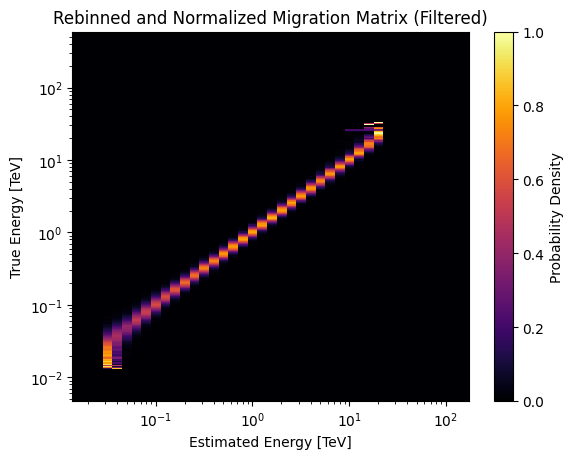

In [10]:
X_new, Y_new = np.meshgrid(E_mid, Eprime_mid_final)

plt.pcolormesh(Y_new.value, X_new.value, new_normalized_matrix.T, cmap='inferno')
plt.xscale('log')
plt.yscale('log')
plt.colorbar(label='Probability Density')
plt.ylabel("True Energy [TeV]")
plt.xlabel("Estimated Energy [TeV]")
plt.title('Rebinned and Normalized Migration Matrix (Filtered)')
# plt.grid(which="both")
plt.show()

In [11]:
#compute the final bins of Estimated energy
E_mid_final, mask_migra_final, E_bins_final = get_E_bins_and_migra(all_observations, Eprime_bins_final, Eprime_mid_final)

In [12]:
aeff = get_aeff(observation, etrue=E_mid, offset=0.4*u.deg, mask_migra=mask_migra_final)

In [13]:
IRF = aeff * new_normalized_matrix.T * livetime#the IRF needed for the simulation includes the exposure, which is the effective area times the livetime.

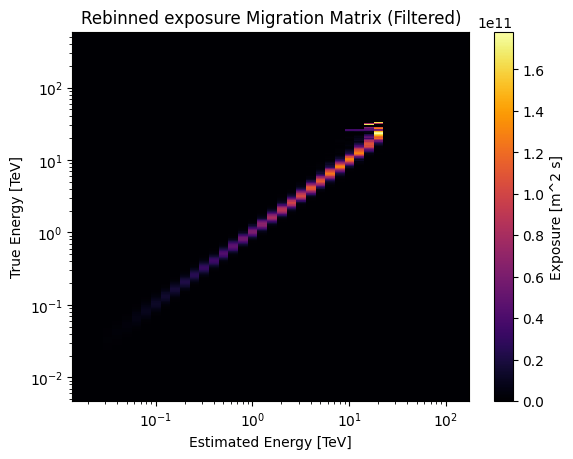

In [14]:
plt.pcolormesh(Y_new.value, X_new.value, IRF, cmap='inferno')
plt.xscale('log')
plt.yscale('log')
plt.colorbar(label='Exposure [m^2 s]')
plt.ylabel("True Energy [TeV]")
plt.xlabel("Estimated Energy [TeV]")
plt.title('Rebinned exposure Migration Matrix (Filtered)')
# plt.grid(which="both")
plt.show()

In [15]:
#save the energy bins and the values of the migration matrix in different files
np.savetxt('migmatCTAalpha/migmatval_50h.txt', IRF.value.T)
np.savetxt('migmatCTAalpha/migmatxEtrue_50h.txt', E_bins.value*1e3) #The IRFs are in TeV and the simulation uses GeV
np.savetxt('migmatCTAalpha/migmatyEest_50h.txt', Eprime_bins_final.value*1e3) #The IRFs are in TeV and the simulation uses GeV
np.savetxt('migmatCTAalpha/Eest_50h.txt', Eprime_mid_final.value*1e3) #The IRFs are in TeV and the simulation uses GeV
np.savetxt('migmatCTAalpha/Etrue_50h.txt', E_mid.value*1e3) #The IRFs are in TeV and the simulation uses GeV

## Now lets compute the background

In [16]:
#define a function to compute the solid angle of a given radius
def compute_solid_angle(radius):
    half_angle = np.radians(radius)
    solid_angle = 2 * np.pi * (1 - np.cos(half_angle))
    return solid_angle*u.sr

In [17]:
bckg_mean = observation.bkg.to_2d().evaluate(offset=0.4*u.deg, energy=Eprime_mid_final) * compute_solid_angle(0.2)
E_prime_mid_edges = Eprime_bins_final[1:] - Eprime_bins_final[:-1]
bckg_int_mean = (bckg_mean * E_prime_mid_edges).to(u.Hz)

In [18]:
final_bckg = (bckg_int_mean * livetime).to(u.dimensionless_unscaled)

In [19]:
theta = observation.psf.containment_radius(energy_true = Eprime_mid_final, offset = 0.4*u.deg, fraction = 0.68)

In [20]:
bckg_corrected = bckg_int_mean /(0.2**2*np.pi) * (theta**2*2*np.pi) * livetime

In [21]:
np.savetxt('migmatCTAalpha/background50h.txt', bckg_corrected.value)